# Setup and Imports


In [1]:
! pip install -q git+https://github.com/keras-team/keras-cv

In [2]:
import os
# You can use `tensorflow`, `pytorch`, `jax` here
# KerasCore makes the notebook backend agnostic :)
os.environ["KERAS_BACKEND"] = "tensorflow"

import keras_cv
import keras_core as keras
from keras_core import layers

import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
# To ignore all warnings
import warnings
warnings.filterwarnings("ignore")

2024-05-26 17:05:33.525858: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-26 17:05:33.526005: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-26 17:05:33.628259: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Using TensorFlow backend


# Configuration

A particularly good practise is to have a configuration class for your notebooks. This not only keeps your configurations all at a single place but also becomes handy to map the configs to the performance of the model.

Please play around with the configurations and see how the performance of the model changes.

## Note on some observations


1. Class Dependencies: Refers to inherent relationships between classes in the analysis.
2. Complementarity: `bowel_injury` and `bowel_healthy`, as well as `extravasation_injury` and `extravasation_healthy`, are perfectly complementary, with their sum always equal to 1.0.
3. Simplification: For the model, only `{bowel/extravasation}_injury` will be included, and the corresponding healthy status can be calculated using a sigmoid function.
4. Softmax: `{kidney/liver/spleen}_{healthy/low/high}` classifications are softmaxed, ensuring their combined probabilities sum up to 1.0 for each organ, simplifying the model while preserving essential information.

In [3]:
class Config:
    SEED = 42
    IMAGE_SIZE = [256, 256]
    BATCH_SIZE = 64
    EPOCHS = 10
    TARGET_COLS  = [
        "bowel_injury", "extravasation_injury",
        "kidney_healthy", "kidney_low", "kidney_high",
        "liver_healthy", "liver_low", "liver_high",
        "spleen_healthy", "spleen_low", "spleen_high",
    ]
    AUTOTUNE = tf.data.AUTOTUNE

config = Config()

# Reproducibility

We would want this notebook to have reproducible results. Here we set the seed for all the random algorithms so that we can reproduce the experiments each time exactly the same way.

In [4]:
keras.utils.set_random_seed(seed=config.SEED)

# Dataset

The dataset provided in the competition consists of DICOM images. We will not be training on the DICOM images, rather would work on PNG image which are extracted from the DICOM format.

[A helpful resource on the conversion of DICOM to PNG](https://www.kaggle.com/code/radek1/how-to-process-dicom-images-to-pngs)

In [5]:
BASE_PATH = f"/kaggle/input/rsna-atd-512x512-png-v2-dataset"

## Meta Data

The `train.csv` file contains the following meta information:

- `patient_id`: A unique ID code for each patient.
- `series_id`: A unique ID code for each scan.
- `instance_number`: The image number within the scan. The lowest instance number for many series is above zero as the original scans were cropped to the abdomen.
- `[bowel/extravasation]_[healthy/injury]`: The two injury types with binary targets.
- `[kidney/liver/spleen]_[healthy/low/high]`: The three injury types with three target levels.
- `any_injury`: Whether the patient had any injury at all.


In [6]:
# train
dataframe = pd.read_csv(f"{BASE_PATH}/train.csv")
dataframe["image_path"] = f"{BASE_PATH}/train_images"\
                    + "/" + dataframe.patient_id.astype(str)\
                    + "/" + dataframe.series_id.astype(str)\
                    + "/" + dataframe.instance_number.astype(str) +".png"
dataframe = dataframe.drop_duplicates()

dataframe.head(2)

,patient_id,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,...,spleen_healthy,spleen_low,spleen_high,any_injury,series_id,instance_number,injury_name,image_path,width,height
0,10004,1,0,0,1,0,1,0,1,0,...,0,0,1,1,21057,362,Active_Extravasation,/kaggle/input/rsna-atd-512x512-png-v2-dataset/...,512,512
1,10004,1,0,0,1,0,1,0,1,0,...,0,0,1,1,21057,363,Active_Extravasation,/kaggle/input/rsna-atd-512x512-png-v2-dataset/...,512,512


We split the training dataset into train and validation. This is a common practise in the Machine Learning pipelines. We not only want to train our model, but also want to validate it's training.

A small catch here is that the training and validation data should have an aligned data distribution. Here we handle that by grouping the lables and then splitting the dataset. This ensures an aligned data distribution between the training and the validation splits.

In [7]:
# Function to handle the split for each group
def split_group(group, test_size=0.2):
    if len(group) == 1:
        return (group, pd.DataFrame()) if np.random.rand() < test_size else (pd.DataFrame(), group)
    else:
        return train_test_split(group, test_size=test_size, random_state=42)

# Initialize the train and validation datasets
train_data = pd.DataFrame()
val_data = pd.DataFrame()

# Iterate through the groups and split them, handling single-sample groups
for _, group in dataframe.groupby(config.TARGET_COLS):
    train_group, val_group = split_group(group)
    train_data = pd.concat([train_data, train_group], ignore_index=True)
    val_data = pd.concat([val_data, val_group], ignore_index=True)

In [8]:
train_data.shape, val_data.shape

((9612, 21), (2417, 21))

## Data Pipeline /w tf.data

Here we build the data pipeline using `tf.data`. Using `tf.data` we can map out data to an augmentation pipeline simple by using the ` map` API.

Adding augmentations to the data pipeline is as simple as adding a layer into the list of layers that the `Augmenter` processes.

Reference: https://keras.io/api/keras_cv/layers/augmentation/

In [9]:
def decode_image_and_label(image_path, label):
    file_bytes = tf.io.read_file(image_path)
    image = tf.io.decode_png(file_bytes, channels=3, dtype=tf.uint8)
    image = tf.image.resize(image, config.IMAGE_SIZE, method="bilinear")
    image = tf.cast(image, tf.float32) / 255.0
    
    label = tf.cast(label, tf.float32)
    #         bowel       fluid       kidney      liver       spleen
    labels = (label[0:1], label[1:2], label[2:5], label[5:8], label[8:11])
    
    return (image, labels)


def apply_augmentation(images, labels):
    augmenter = keras_cv.layers.Augmenter(
        [
            keras_cv.layers.RandomFlip(mode="horizontal_and_vertical"),
            keras_cv.layers.RandomCutout(height_factor=0.2, width_factor=0.2),
            
        ]
    )
    return (augmenter(images), labels)


def build_dataset(image_paths, labels):
    ds = (
        tf.data.Dataset.from_tensor_slices((image_paths, labels))
        .map(decode_image_and_label, num_parallel_calls=config.AUTOTUNE)
        .shuffle(config.BATCH_SIZE * 10)
        .batch(config.BATCH_SIZE)
        .map(apply_augmentation, num_parallel_calls=config.AUTOTUNE)
        .prefetch(config.AUTOTUNE)
    )
    return ds

In [10]:
paths  = train_data.image_path.tolist()
labels = train_data[config.TARGET_COLS].values

ds = build_dataset(image_paths=paths, labels=labels)
images, labels = next(iter(ds))
images.shape, [label.shape for label in labels]

(TensorShape([64, 256, 256, 3]),
 [TensorShape([64, 1]),
  TensorShape([64, 1]),
  TensorShape([64, 3]),
  TensorShape([64, 3]),
  TensorShape([64, 3])])

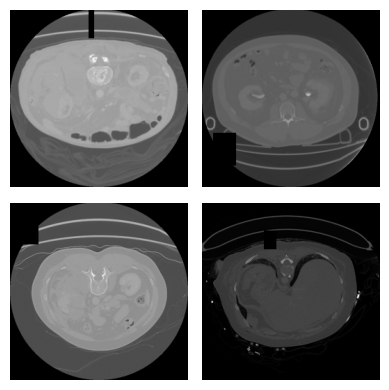

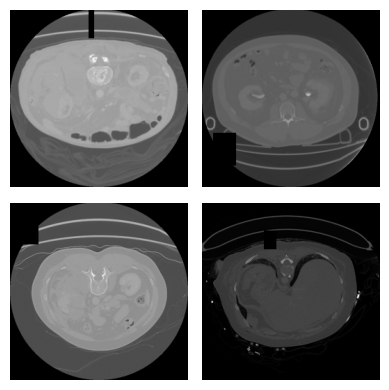

In [11]:
# No more customizing your plots by hand, KerasCV has your back ;)
keras_cv.visualization.plot_image_gallery(
    images=images,
    value_range=(0, 1),
    rows=2,
    cols=2,
)

# Build Model



In [12]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D

def build_model(warmup_steps, decay_steps):
    # Define Input
    inputs = keras.Input(shape=config.IMAGE_SIZE + [3,], batch_size=config.BATCH_SIZE)

    # Use ResNet50 as the backbone
    backbone = ResNet50(weights='imagenet', include_top=False)
    x = backbone(inputs)

    # GAP to get the activation maps
    x = GlobalAveragePooling2D()(x)

    # Define 'necks' for each head
    x_bowel = Dense(32, activation='silu')(x)
    x_extra = Dense(32, activation='silu')(x)
    x_liver = Dense(32, activation='silu')(x)
    x_kidney = Dense(32, activation='silu')(x)
    x_spleen = Dense(32, activation='silu')(x)

    # Define heads
    out_bowel = Dense(1, name='bowel', activation='sigmoid')(x_bowel)
    out_extra = Dense(1, name='extra', activation='sigmoid')(x_extra)
    out_liver = Dense(3, name='liver', activation='softmax')(x_liver)
    out_kidney = Dense(3, name='kidney', activation='softmax')(x_kidney)
    out_spleen = Dense(3, name='spleen', activation='softmax')(x_spleen)

    # Concatenate the outputs
    outputs = [out_bowel, out_extra, out_liver, out_kidney, out_spleen]

    # Create model
    print("[INFO] Building the model...")
    model = keras.Model(inputs=inputs, outputs=outputs)

    # Cosine Decay
    cosine_decay = keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=1e-4,
        decay_steps=decay_steps,
        alpha=0.0,
        warmup_target=1e-3,
        warmup_steps=warmup_steps,
    )

    # Compile the model
    optimizer = keras.optimizers.Adam(learning_rate=cosine_decay)
    loss = {
        "bowel": keras.losses.BinaryCrossentropy(),
        "extra": keras.losses.BinaryCrossentropy(),
        "liver": keras.losses.CategoricalCrossentropy(),
        "kidney": keras.losses.CategoricalCrossentropy(),
        "spleen": keras.losses.CategoricalCrossentropy(),
    }
    metrics = {
        "bowel": ["accuracy"],
        "extra": ["accuracy"],
        "liver": ["accuracy"],
        "kidney": ["accuracy"],
        "spleen": ["accuracy"],
    }
    print("[INFO] Compiling the model...")
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=metrics
    )

    return model


In [13]:
# Assuming you have already defined the necessary functions like build_dataset

# Build the dataset
print("[INFO] Building the dataset...")
train_paths = train_data.image_path.values
train_labels = train_data[config.TARGET_COLS].values.astype(np.float32)
valid_paths = val_data.image_path.values
valid_labels = val_data[config.TARGET_COLS].values.astype(np.float32)

# Train and valid datasets
train_ds = build_dataset(image_paths=train_paths, labels=train_labels)
val_ds = build_dataset(image_paths=valid_paths, labels=valid_labels)

total_train_steps = train_ds.cardinality().numpy() * config.BATCH_SIZE * config.EPOCHS
warmup_steps = int(total_train_steps * 0.10)
decay_steps = total_train_steps - warmup_steps

print(f"{total_train_steps=}")
print(f"{warmup_steps=}")
print(f"{decay_steps=}")

# Build the model
print("[INFO] Building the model...")
model = build_model(warmup_steps, decay_steps)

# Train
print("[INFO] Training...")
history = model.fit(
    train_ds,
    epochs=config.EPOCHS,
    validation_data=val_ds,
)


[INFO] Building the dataset...
total_train_steps=96640
warmup_steps=9664
decay_steps=86976
[INFO] Building the model...
94765736/94765736 [==============================] - 5s 0us/step
[INFO] Building the model...
[INFO] Compiling the model...
[INFO] Training...
Epoch 1/10


I0000 00:00:1716743195.204913     101 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


151/151 [==============================] - 145s 657ms/step - loss: 1.4978 - bowel_loss: 0.1563 - extra_loss: 0.3189 - liver_loss: 0.2608 - kidney_loss: 0.3279 - spleen_loss: 0.4339 - bowel_accuracy: 0.9512 - extra_accuracy: 0.8781 - liver_accuracy: 0.9102 - kidney_accuracy: 0.8794 - spleen_accuracy: 0.8407 - val_loss: 6.3565 - val_bowel_loss: 2.3372 - val_extra_loss: 0.6134 - val_liver_loss: 0.7121 - val_kidney_loss: 0.8437 - val_spleen_loss: 1.8501 - val_bowel_accuracy: 0.5205 - val_extra_accuracy: 0.6967 - val_liver_accuracy: 0.8697 - val_kidney_accuracy: 0.8113 - val_spleen_accuracy: 0.6773
Epoch 2/10
151/151 [==============================] - 86s 555ms/step - loss: 1.7358 - bowel_loss: 0.3094 - extra_loss: 0.2877 - liver_loss: 0.3887 - kidney_loss: 0.3471 - spleen_loss: 0.4029 - bowel_accuracy: 0.9074 - extra_accuracy: 0.8920 - liver_accuracy: 0.8892 - kidney_accuracy: 0.8797 - spleen_accuracy: 0.8603 - val_loss: 11.5951 - val_bowel_loss: 2.2853 - val_extra_loss: 3.6106 - val_liver

## Visualize the training plots

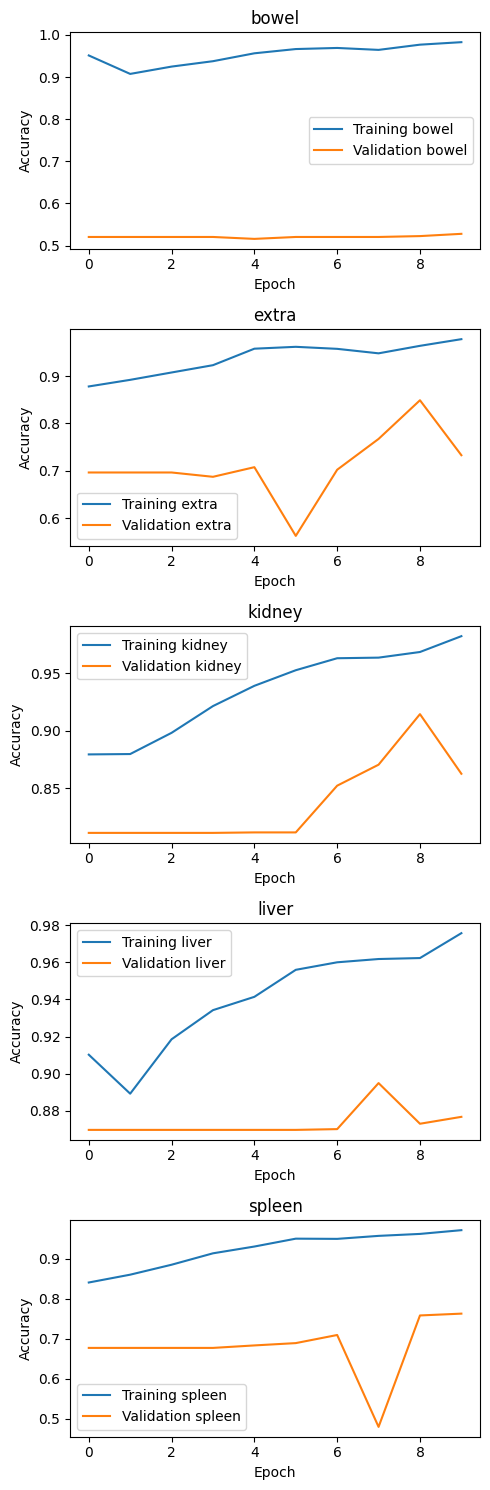

In [14]:
# Create a 3x2 grid for the subplots
fig, axes = plt.subplots(5, 1, figsize=(5, 15))

# Flatten axes to iterate through them
axes = axes.flatten()

# Iterate through the metrics and plot them
for i, name in enumerate(["bowel", "extra", "kidney", "liver", "spleen"]):
    # Plot training accuracy
    axes[i].plot(history.history[name + '_accuracy'], label='Training ' + name)
    # Plot validation accuracy
    axes[i].plot(history.history['val_' + name + '_accuracy'], label='Validation ' + name)
    axes[i].set_title(name)
    axes[i].set_xlabel('Epoch')
    axes[i].set_ylabel('Accuracy')
    axes[i].legend()

plt.tight_layout()
plt.show()

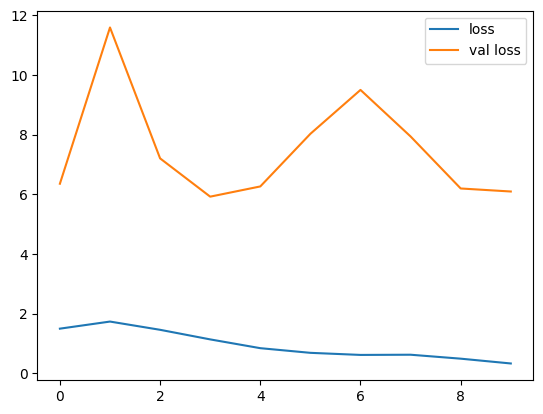

In [15]:
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val loss")
plt.legend()
plt.show()

In [16]:
# store best results
best_epoch = np.argmin(history.history['val_loss'])
best_loss = history.history['val_loss'][best_epoch]
best_acc_bowel = history.history['val_bowel_accuracy'][best_epoch]
best_acc_extra = history.history['val_extra_accuracy'][best_epoch]
best_acc_liver = history.history['val_liver_accuracy'][best_epoch]
best_acc_kidney = history.history['val_kidney_accuracy'][best_epoch]
best_acc_spleen = history.history['val_spleen_accuracy'][best_epoch]

# Find mean accuracy
best_acc = np.mean(
    [best_acc_bowel,
     best_acc_extra,
     best_acc_liver,
     best_acc_kidney,
     best_acc_spleen
])


print(f'>>>> BEST Loss  : {best_loss:.3f}\n>>>> BEST Acc   : {best_acc:.3f}\n>>>> BEST Epoch : {best_epoch}\n')
print('ORGAN Acc:')
print(f'  >>>> {"Bowel".ljust(15)} : {best_acc_bowel:.3f}')
print(f'  >>>> {"Extravasation".ljust(15)} : {best_acc_extra:.3f}')
print(f'  >>>> {"Liver".ljust(15)} : {best_acc_liver:.3f}')
print(f'  >>>> {"Kidney".ljust(15)} : {best_acc_kidney:.3f}')
print(f'  >>>> {"Spleen".ljust(15)} : {best_acc_spleen:.3f}')

>>>> BEST Loss  : 5.923
>>>> BEST Acc   : 0.713
>>>> BEST Epoch : 3

ORGAN Acc:
  >>>> Bowel           : 0.520
  >>>> Extravasation   : 0.688
  >>>> Liver           : 0.870
  >>>> Kidney          : 0.811
  >>>> Spleen          : 0.677


## Store the model for inference

In [17]:
# Save the model
model.save("rsna-atd.keras")